In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
data_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/dotcsv/UNet_Segmentation/Transfer learning/ocean_v2')


In [3]:
data_dir

PosixPath('/content/drive/MyDrive/Colab Notebooks/dotcsv/UNet_Segmentation/Transfer learning/ocean_v2')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2855


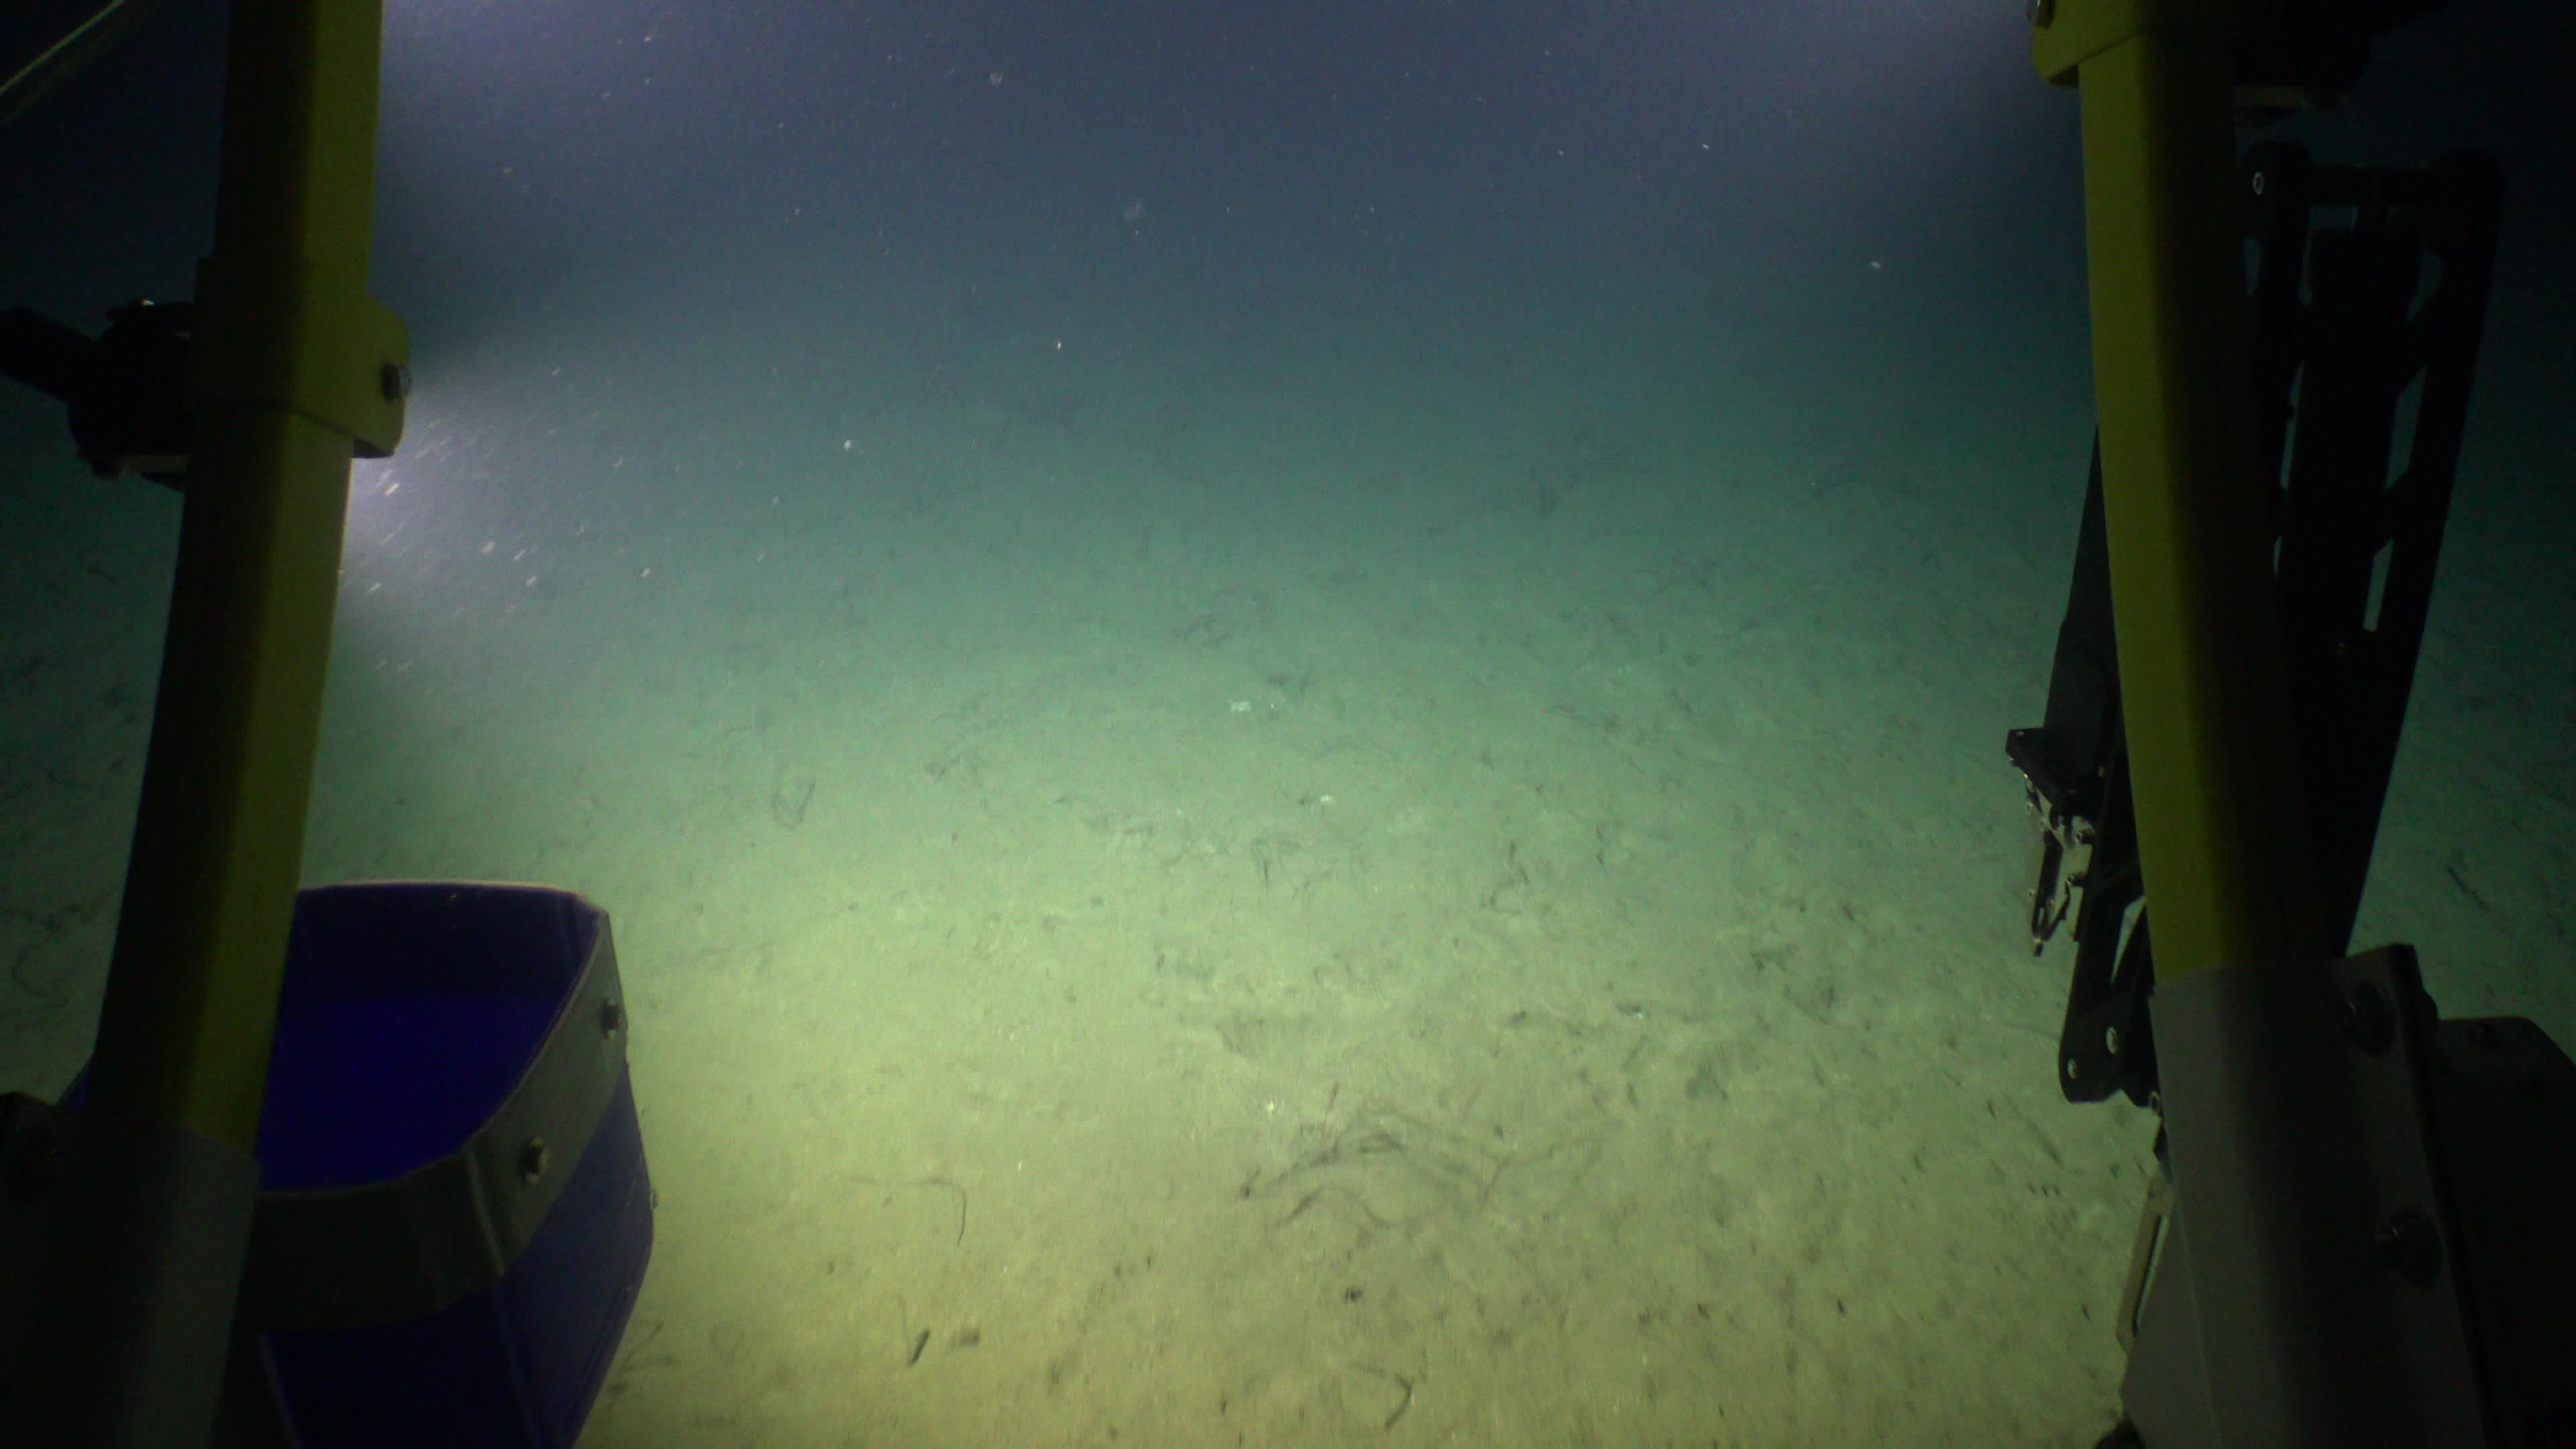

In [6]:
arenofangoso = list(data_dir.glob('arenofangoso/*'))
PIL.Image.open(str(arenofangoso[10]))

In [5]:
batch_size = 32
img_height = 256
img_width = 256

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2855 files belonging to 4 classes.
Using 2284 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2855 files belonging to 4 classes.
Using 571 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['arenofangoso', 'arenoso', 'arrecife', 'fangoso']


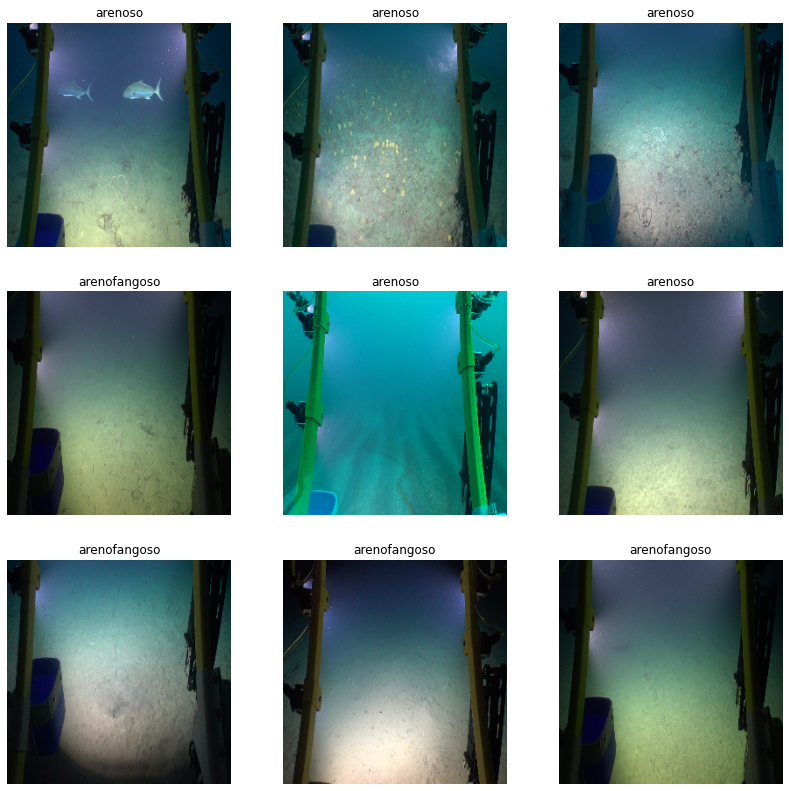

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 14))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.07),
  #layers.experimental.preprocessing.RandomZoom(0.1),
])

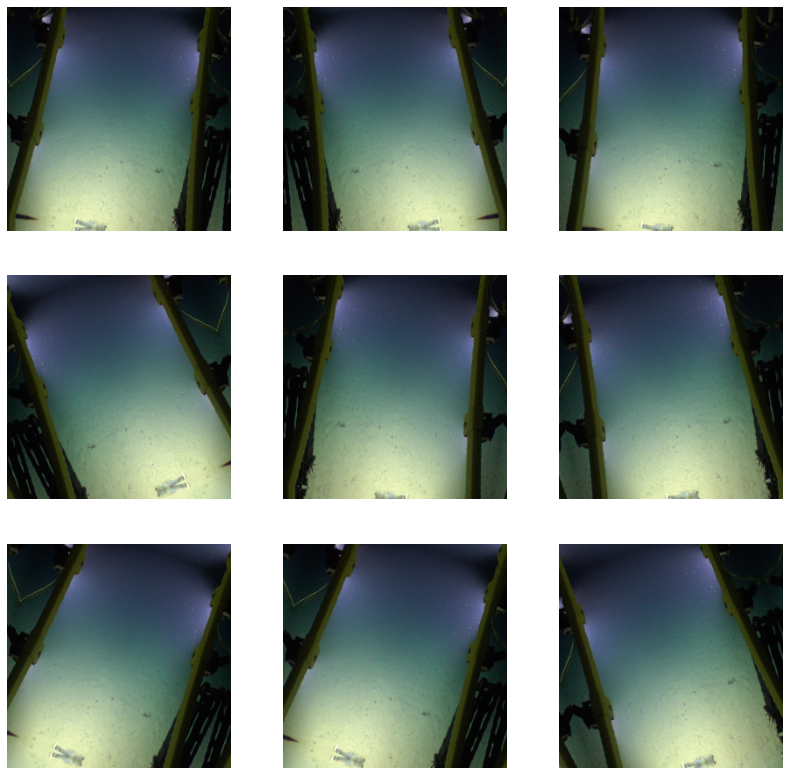

In [12]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(14, 14))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [13]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input

conv_model = VGG19(weights='imagenet', include_top=False, input_shape=(256,256,3))

80150528/80134624 [==============================] - 1s 0us/step


In [15]:
inputs = tf.keras.Input(shape=(256, 256, 3))

conv_model.trainable = False

x = data_augmentation(inputs)

x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(32, activation='relu')(x)

predictions = keras.layers.Dense(len(class_names))(x)

full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

In [16]:
full_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [17]:
base_learning_rate = 0.0001
full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
history = full_model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/10
72/72 [==============================] - 197s 2s/step - loss: 0.3127 - accuracy: 0.9124 - val_loss: 0.0816 - val_accuracy: 0.9667
Epoch 2/10
72/72 [==============================] - 32s 448ms/step - loss: 0.0584 - accuracy: 0.9759 - val_loss: 0.0673 - val_accuracy: 0.9790
Epoch 3/10
72/72 [==============================] - 32s 447ms/step - loss: 0.0418 - accuracy: 0.9838 - val_loss: 0.0570 - val_accuracy: 0.9807
Epoch 4/10
72/72 [==============================] - 32s 448ms/step - loss: 0.0213 - accuracy: 0.9934 - val_loss: 0.0631 - val_accuracy: 0.9685
Epoch 5/10
72/72 [==============================] - 32s 447ms/step - loss: 0.0165 - accuracy: 0.9939 - val_loss: 0.0431 - val_accuracy: 0.9877
Epoch 6/10
72/72 [==============================] - 32s 447ms/step - loss: 0.0106 - accuracy: 0.9978 - val_loss: 0.0386 - val_accuracy: 0.9842
Epoch 7/10
72/72 [==============================] - 32s 447ms/step - loss: 0.0115 - accuracy: 0.9956 - val_loss: 0.0503 - val_accuracy: 0.9790
E

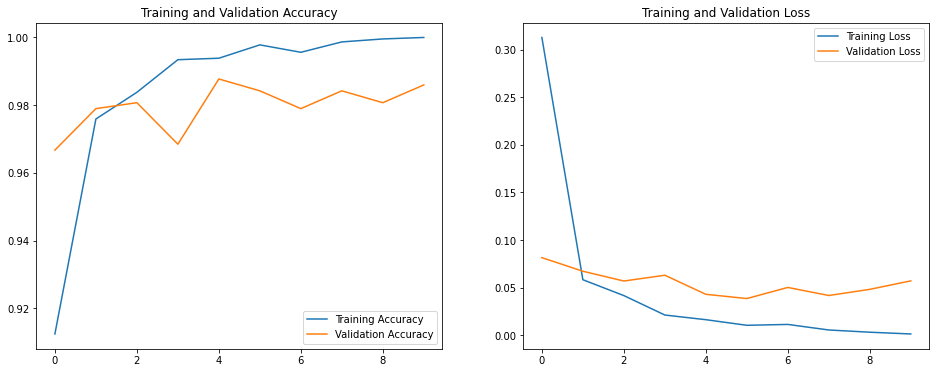

In [22]:
epochs=10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
full_model.save('/content/drive/MyDrive/Colab Notebooks/dotcsv/UNet_Segmentation/Transfer learning/path_to_my_model.h5')